## Importing Modules and Dataset

In [1]:
import numpy as np
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt
from sklearn.feature_selection import chi2
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix

In [2]:
df = pd.read_csv("mqttdataset_reduced.csv")
df.head()

,tcp.flags,tcp.time_delta,tcp.len,mqtt.conack.flags,mqtt.conack.flags.reserved,mqtt.conack.flags.sp,mqtt.conack.val,mqtt.conflag.cleansess,mqtt.conflag.passwd,mqtt.conflag.qos,...,mqtt.qos,mqtt.retain,mqtt.sub.qos,mqtt.suback.qos,mqtt.ver,mqtt.willmsg,mqtt.willmsg_len,mqtt.willtopic,mqtt.willtopic_len,target
0,0x00000010,0.000019,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,legitimate
1,0x00000018,0.000000,90,0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,dos
2,0x00000018,0.000001,8,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,dos
3,0x00000018,0.000001,85,0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,dos
4,0x00000010,0.000004,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,legitimate


Project only focuses on identifying dos attack hence we filter the rows related to dos attacks and legitimate data.

In [3]:
df = df[(df["target"] == "legitimate") | (df["target"] == "dos")]
df["target"].unique()

array(['legitimate', 'dos'], dtype=object)

## Cleaning and Preprocessing of Dataset

In [4]:
df.shape

(295686, 34)

Checking if any columns have empty values. The dataset is found to be clean.

In [5]:
df.isna().any()

tcp.flags                     False
tcp.time_delta                False
tcp.len                       False
mqtt.conack.flags             False
mqtt.conack.flags.reserved    False
mqtt.conack.flags.sp          False
mqtt.conack.val               False
mqtt.conflag.cleansess        False
mqtt.conflag.passwd           False
mqtt.conflag.qos              False
mqtt.conflag.reserved         False
mqtt.conflag.retain           False
mqtt.conflag.uname            False
mqtt.conflag.willflag         False
mqtt.conflags                 False
mqtt.dupflag                  False
mqtt.hdrflags                 False
mqtt.kalive                   False
mqtt.len                      False
mqtt.msg                      False
mqtt.msgid                    False
mqtt.msgtype                  False
mqtt.proto_len                False
mqtt.protoname                False
mqtt.qos                      False
mqtt.retain                   False
mqtt.sub.qos                  False
mqtt.suback.qos             

Checking the data types of each columns. We can find that the columns are both numerical and object types and we need to do feature handling accordingly.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 295686 entries, 0 to 330925
Data columns (total 34 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   tcp.flags                   295686 non-null  object 
 1   tcp.time_delta              295686 non-null  float64
 2   tcp.len                     295686 non-null  int64  
 3   mqtt.conack.flags           295686 non-null  object 
 4   mqtt.conack.flags.reserved  295686 non-null  float64
 5   mqtt.conack.flags.sp        295686 non-null  float64
 6   mqtt.conack.val             295686 non-null  float64
 7   mqtt.conflag.cleansess      295686 non-null  float64
 8   mqtt.conflag.passwd         295686 non-null  float64
 9   mqtt.conflag.qos            295686 non-null  float64
 10  mqtt.conflag.reserved       295686 non-null  float64
 11  mqtt.conflag.retain         295686 non-null  float64
 12  mqtt.conflag.uname          295686 non-null  float64
 13  mqtt.conflag.willfl

Normalization of the numerical data. 

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [8]:
numerical_features = df.columns[df.dtypes != 'object']
if len(numerical_features) > 0:
    df[numerical_features] = scaler.fit_transform(df[numerical_features])

In [9]:
df

,tcp.flags,tcp.time_delta,tcp.len,mqtt.conack.flags,mqtt.conack.flags.reserved,mqtt.conack.flags.sp,mqtt.conack.val,mqtt.conflag.cleansess,mqtt.conflag.passwd,mqtt.conflag.qos,...,mqtt.qos,mqtt.retain,mqtt.sub.qos,mqtt.suback.qos,mqtt.ver,mqtt.willmsg,mqtt.willmsg_len,mqtt.willtopic,mqtt.willtopic_len,target
0,0x00000010,3.166623e-07,0.000000,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,legitimate
1,0x00000018,0.000000e+00,0.061644,0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,dos
2,0x00000018,1.666644e-08,0.005479,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,dos
3,0x00000018,1.666644e-08,0.058219,0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,dos
4,0x00000010,6.666575e-08,0.000000,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,legitimate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330921,0x00000010,4.999931e-08,0.000000,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,legitimate
330922,0x00000010,1.221650e-05,1.000000,0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,dos
330923,0x00000010,5.666589e-07,0.000000,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,dos
330924,0x00000010,1.133318e-06,1.000000,0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,dos


Encoding of Categorical Data (Object)

In [10]:
label_encoder = LabelEncoder()

In [11]:
df["tcp.flags"].unique()

array(['0x00000010', '0x00000018', '0x00000011', '0x00000002',
       '0x00000012'], dtype=object)

In [12]:
df['tcp.flags'] = label_encoder.fit_transform(df['tcp.flags'])
df['tcp.flags'].unique()

array([1, 4, 2, 0, 3])

In [13]:
df["mqtt.conack.flags"].unique()

array(['0', '0x00000000'], dtype=object)

In [14]:
df = df.replace(["0", "0x00000000"], 0)
df['mqtt.conack.flags'].unique()

C:\Users\Nivedhidha\AppData\Local\Temp\ipykernel_21252\449210059.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(["0", "0x00000000"], 0)


array([0], dtype=int64)

In [15]:
df['mqtt.conflags'] = df['mqtt.conflags'].astype(str)
df["mqtt.conflags"].unique()

array(['0', '0x00000002'], dtype=object)

In [16]:
df['mqtt.conflags'] = label_encoder.fit_transform(df['mqtt.conflags'])
df['mqtt.conflags'].unique()

array([0, 1])

In [17]:
df['mqtt.hdrflags'] = df['mqtt.hdrflags'].astype(str)
df["mqtt.hdrflags"].unique()

array(['0', '0x00000032', '0x00000040', '0x00000030', '0x000000c0',
       '0x0000003a', '0x000000d0', '0x00000020', '0x000000e0',
       '0x00000010'], dtype=object)

In [18]:
df['mqtt.hdrflags'] = label_encoder.fit_transform(df['mqtt.hdrflags'])
df['mqtt.hdrflags'].unique()

array([0, 4, 6, 3, 7, 5, 8, 2, 9, 1])

For now the mqtt.msg data has been considered based on the message length. We will perform text encoding.

In [19]:
df['mqtt.msg'] = df['mqtt.msg'].astype(str)
df["mqtt.msg"].unique()

array(['0',
       '386531656333434642316644363961453041413137623730433638324233396161396637323434384433453331443938614365323332343041643564314464643134654530354442446365393535374546654643636563313143446265303561',
       '313143333966446635386233364132634646346366464635636441354335636643443646636534426635346364334635366443653935426444436462366634413664614142393831423834364437346333413834656134383542384463364345',
       ...,
       '303241433939363237383864383461356437354138614366454346414544336266423163334143394562346465626142443034393235316344636332423339363044636539346531364137304435613066323042653735393336373435426437363045',
       '334641643541353331614443623741364137613662613437423939346462416134383737654262323563416132644166624534456462426541666438633845426562424241634661363064656131434231323966343230363363454537376262394630',
       '456138443133306666613636666639396535623242653032334243633544366333636537453230416441643730626245333264396132356430363232366566346561316537383446

In [20]:
df["msg_len"] = [len(val) for val in df["mqtt.msg"].to_list()]
df = df.drop('mqtt.msg', axis=1)
df["msg_len"].unique()

array([  1, 192, 204,   4, 188,   2, 200,   6, 208, 186, 202, 198, 210,
       194, 196, 180, 184, 182, 190, 206, 164, 220, 212, 178, 214, 166,
       216, 176, 222, 224, 218, 174,   8, 228, 170, 172, 226, 234, 168,
       230, 238, 232, 162, 240, 160, 236], dtype=int64)

In [21]:
df['mqtt.protoname'] = df['mqtt.protoname'].astype(str)
df["mqtt.protoname"].unique()

array(['0', 'MQTT'], dtype=object)

In [22]:
df['mqtt.protoname'] = label_encoder.fit_transform(df['mqtt.protoname'])
df["mqtt.protoname"].unique()

array([0, 1])

In [23]:
df["target"].unique()

array(['legitimate', 'dos'], dtype=object)

In [24]:
label_encoder.fit(["legitimate", "dos"])
mapping = {"legitimate": 0, "dos": 1}
df["target"] = [mapping[label] for label in df["target"].to_list()]
df["target"].unique()

array([0, 1], dtype=int64)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 295686 entries, 0 to 330925
Data columns (total 34 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   tcp.flags                   295686 non-null  int32  
 1   tcp.time_delta              295686 non-null  float64
 2   tcp.len                     295686 non-null  float64
 3   mqtt.conack.flags           295686 non-null  int64  
 4   mqtt.conack.flags.reserved  295686 non-null  float64
 5   mqtt.conack.flags.sp        295686 non-null  float64
 6   mqtt.conack.val             295686 non-null  float64
 7   mqtt.conflag.cleansess      295686 non-null  float64
 8   mqtt.conflag.passwd         295686 non-null  float64
 9   mqtt.conflag.qos            295686 non-null  float64
 10  mqtt.conflag.reserved       295686 non-null  float64
 11  mqtt.conflag.retain         295686 non-null  float64
 12  mqtt.conflag.uname          295686 non-null  float64
 13  mqtt.conflag.willfl

## Analysing the Dataset

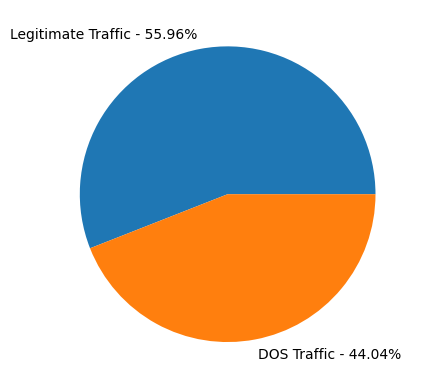

In [26]:
target_x = df["target"].unique()
target_l = list(df["target"])
target_y = []
for i in target_x:
    target_y.append(round(target_l.count(i)*100/len(target_l), 2))
plt.pie(target_y, labels=["Legitimate Traffic - " + str(target_y[0]) + "%", "DOS Traffic - " + str(target_y[1]) + "%"])
plt.show()

We can see that the dataset is not balanced, hence we will be using the algorithms which are less affected by unbalanced datasets. 
* Decision Trees
* Random Forests
* Support Vector Machines (SVMs) - not used in this project as SVM doesn't work well with large datasets.

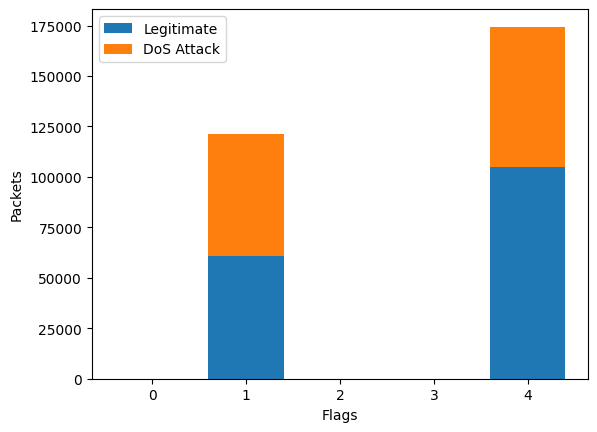

In [27]:
tcp_flag_x = list(df["tcp.flags"].unique())

tcp_flag_l_top = list(df[df["target"]==1]["tcp.flags"])
tcp_flag_y_top = []
for i in tcp_flag_x:
    tcp_flag_y_top.append(tcp_flag_l_top.count(i))

tcp_flag_l_bottom = list(df[df["target"]==0]["tcp.flags"])
tcp_flag_y_bottom = []
for i in tcp_flag_x:
    tcp_flag_y_bottom.append(tcp_flag_l_bottom.count(i))

plt.bar(tcp_flag_x, tcp_flag_y_bottom, label="Legitimate")
plt.bar(tcp_flag_x, tcp_flag_y_top, bottom=tcp_flag_y_bottom, label="DoS Attack")

plt.legend()
plt.xlabel('Flags')
plt.ylabel('Packets')
plt.show()

We can see in the graph that the majority of the flags are either SYN or RST flags.

1 -> '0x00000010' [SYN (Synchronization) flag]

4 -> '0x00000018' [Reset (RST) flag]

2 -> '0x00000011' [Urgent (URG) and Acknowledgment (ACK) flag]

0 -> '0x00000002' [Conditional Receive (CWR) flag]

3 -> '0x00000012' [PUSH (PSH) flag]

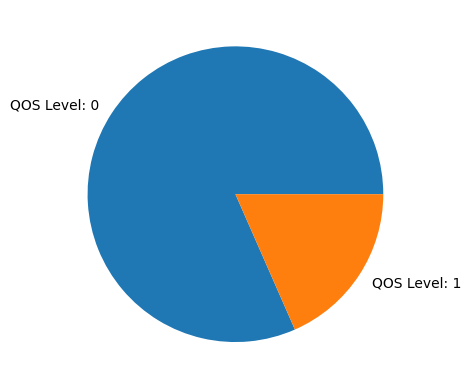

In [28]:
qos_x = df["mqtt.qos"].unique()
qos_l = list(df["mqtt.qos"])
qos_y = []

for i in qos_x:
    qos_y.append(qos_l.count(i))
plt.pie(qos_y, labels=["QOS Level: 0", "QOS Level: 1"])
plt.show()

Majority of the packets have been sent using QOS 0.

## Feature Engineering

In [29]:
x = df.drop('target', axis=1)
x

,tcp.flags,tcp.time_delta,tcp.len,mqtt.conack.flags,mqtt.conack.flags.reserved,mqtt.conack.flags.sp,mqtt.conack.val,mqtt.conflag.cleansess,mqtt.conflag.passwd,mqtt.conflag.qos,...,mqtt.qos,mqtt.retain,mqtt.sub.qos,mqtt.suback.qos,mqtt.ver,mqtt.willmsg,mqtt.willmsg_len,mqtt.willtopic,mqtt.willtopic_len,msg_len
0,1,3.166623e-07,0.000000,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,4,0.000000e+00,0.061644,0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,192
2,4,1.666644e-08,0.005479,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,4,1.666644e-08,0.058219,0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,192
4,1,6.666575e-08,0.000000,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330921,1,4.999931e-08,0.000000,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
330922,1,1.221650e-05,1.000000,0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,198
330923,1,5.666589e-07,0.000000,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
330924,1,1.133318e-06,1.000000,0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,204


In [30]:
y = df["target"]
y

0         0
1         1
2         1
3         1
4         0
         ..
330921    0
330922    1
330923    1
330924    1
330925    0
Name: target, Length: 295686, dtype: int64

SelectKBest with chi-square test has been used to select top 20 features. The feature selection process is done independently of any specific machine learning algorithm. It relies on statistical measures to score and rank the features.

In [31]:
selector = SelectKBest(chi2, k=20)
X_reduced = selector.fit_transform(x, y)
all_features = x.columns.tolist()
select_x = [all_features[i] for i in selector.get_support(indices=True)]
select_x

['tcp.flags',
 'tcp.time_delta',
 'tcp.len',
 'mqtt.conflag.cleansess',
 'mqtt.conflags',
 'mqtt.dupflag',
 'mqtt.hdrflags',
 'mqtt.kalive',
 'mqtt.len',
 'mqtt.msgid',
 'mqtt.msgtype',
 'mqtt.proto_len',
 'mqtt.protoname',
 'mqtt.qos',
 'mqtt.ver',
 'mqtt.willmsg',
 'mqtt.willmsg_len',
 'mqtt.willtopic',
 'mqtt.willtopic_len',
 'msg_len']

Feature importance with Random Forest has been used to select the top 20 features. This feature selection is done using Random Forest Algorithm as Random Forest inheritly provides the importance scores based on how much a feature contributes to the prediction. 

In [32]:
model = RandomForestClassifier(n_estimators=100)
model.fit(x, y)

feature_importances = model.feature_importances_

top_k_features = np.argsort(feature_importances)[::-1][:20]

random_x = []
for i in top_k_features:
    random_x.append(x.keys()[i])
random_x = list(random_x)
random_x

['mqtt.msgid',
 'mqtt.hdrflags',
 'tcp.len',
 'mqtt.len',
 'mqtt.qos',
 'msg_len',
 'mqtt.msgtype',
 'tcp.time_delta',
 'tcp.flags',
 'mqtt.dupflag',
 'mqtt.protoname',
 'mqtt.conflag.cleansess',
 'mqtt.conflags',
 'mqtt.ver',
 'mqtt.kalive',
 'mqtt.proto_len',
 'mqtt.conack.val',
 'mqtt.conack.flags.sp',
 'mqtt.conack.flags',
 'mqtt.conack.flags.reserved']

In [33]:
feature_names = list(set(random_x) & set(select_x))
feature_names

['mqtt.hdrflags',
 'mqtt.qos',
 'mqtt.protoname',
 'mqtt.conflag.cleansess',
 'msg_len',
 'mqtt.msgid',
 'mqtt.proto_len',
 'tcp.time_delta',
 'mqtt.msgtype',
 'mqtt.kalive',
 'mqtt.ver',
 'mqtt.len',
 'tcp.flags',
 'tcp.len',
 'mqtt.conflags',
 'mqtt.dupflag']

In [34]:
features = {}
for i in feature_names:
    features[i] = x[i]
features = pd.DataFrame(features)
x = features
x

,mqtt.hdrflags,mqtt.qos,mqtt.protoname,mqtt.conflag.cleansess,msg_len,mqtt.msgid,mqtt.proto_len,tcp.time_delta,mqtt.msgtype,mqtt.kalive,mqtt.ver,mqtt.len,tcp.flags,tcp.len,mqtt.conflags,mqtt.dupflag
0,0,0.0,0,0.0,1,0.0000,0.0,3.166623e-07,0.000000,0.0,0.0,0.000000,1,0.000000,0,0.0
1,4,1.0,0,0.0,192,0.0273,0.0,0.000000e+00,0.214286,0.0,0.0,0.868421,4,0.061644,0,0.0
2,6,0.0,0,0.0,1,0.4196,0.0,1.666644e-08,0.285714,0.0,0.0,0.010526,4,0.005479,0,0.0
3,4,1.0,0,0.0,192,0.2973,0.0,1.666644e-08,0.214286,0.0,0.0,0.868421,4,0.058219,0,0.0
4,0,0.0,0,0.0,1,0.0000,0.0,6.666575e-08,0.000000,0.0,0.0,0.000000,1,0.000000,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330921,0,0.0,0,0.0,1,0.0000,0.0,4.999931e-08,0.000000,0.0,0.0,0.000000,1,0.000000,0,0.0
330922,4,1.0,0,0.0,198,0.0144,0.0,1.221650e-05,0.214286,0.0,0.0,0.878947,1,1.000000,0,0.0
330923,0,0.0,0,0.0,1,0.0000,0.0,5.666589e-07,0.000000,0.0,0.0,0.000000,1,0.000000,0,0.0
330924,4,1.0,0,0.0,204,0.7512,0.0,1.133318e-06,0.214286,0.0,0.0,0.905263,1,1.000000,0,0.0


## Model Building

In [35]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42)

Dataset has been split into training (60%), validation (20%) and testing (20%) datasets.

As discussed before during analysis, we will focus on the algorithms - Decision Tree and Random Forest.

### Decision Tree Algorithm

Default Parameter

In [36]:
clf = DecisionTreeClassifier()
clf.fit(x_train, y_train)

DecisionTreeClassifier()

In [37]:
y_cal = clf.predict(x_val)

print("Decision Tree - Trial 1")
print("-----------------------\n")

auc_roc = round(roc_auc_score(y_val, y_cal)*100, 2)
accuracy = round(accuracy_score(y_val, y_cal)*100, 2)
f1 = round(f1_score(y_val, y_cal)*100, 2)
cm = confusion_matrix(y_val, y_cal)

print("AUC-ROC Score: ", auc_roc, "%", sep="")
print("Accuracy Score: ", accuracy, "%", sep="")
print("F1 Score: ", f1, "%", sep="")
print("Confusion Matrix:\n", tabulate(cm, tablefmt="grid"), sep="")

Decision Tree - Trial 1
-----------------------

AUC-ROC Score: 86.14%
Accuracy Score: 87.83%
F1 Score: 83.91%
Confusion Matrix:
+-------+-------+
| 33180 |     0 |
+-------+-------+
|  7197 | 18760 |
+-------+-------+


Hypertuning Parameters

criterian Parameter 

In [38]:
param_grid = {
    "criterion": ["gini", "entropy", "log_loss"] # default - "gini"
}

clf = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
clf.fit(x_train, y_train)

print(clf.best_params_)

{'criterion': 'gini'}


In [39]:
y_cal = clf.predict(x_val)

print("Decision Tree - Trial 2")
print("-----------------------\n")

auc_roc = round(roc_auc_score(y_val, y_cal)*100, 2)
accuracy = round(accuracy_score(y_val, y_cal)*100, 2)
f1 = round(f1_score(y_val, y_cal)*100, 2)
cm = confusion_matrix(y_val, y_cal)

print("AUC-ROC Score: ", auc_roc, "%", sep="")
print("Accuracy Score: ", accuracy, "%", sep="")
print("F1 Score: ", f1, "%", sep="")
print("Confusion Matrix:\n", tabulate(cm, tablefmt="grid"), sep="")

Decision Tree - Trial 2
-----------------------

AUC-ROC Score: 86.14%
Accuracy Score: 87.83%
F1 Score: 83.91%
Confusion Matrix:
+-------+-------+
| 33180 |     0 |
+-------+-------+
|  7197 | 18760 |
+-------+-------+


splitter Parameter

In [40]:
param_grid = {
    "splitter": ["best", "random"] # default - "best"
}

clf = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
clf.fit(x_train, y_train)

print(clf.best_params_)

{'splitter': 'random'}


In [41]:
y_cal = clf.predict(x_val)

print("Decision Tree - Trial 3")
print("-----------------------\n")

auc_roc = round(roc_auc_score(y_val, y_cal)*100, 2)
accuracy = round(accuracy_score(y_val, y_cal)*100, 2)
f1 = round(f1_score(y_val, y_cal)*100, 2)
cm = confusion_matrix(y_val, y_cal)

print("AUC-ROC Score: ", auc_roc, "%", sep="")
print("Accuracy Score: ", accuracy, "%", sep="")
print("F1 Score: ", f1, "%", sep="")
print("Confusion Matrix:\n", tabulate(cm, tablefmt="grid"), sep="")

Decision Tree - Trial 3
-----------------------

AUC-ROC Score: 95.07%
Accuracy Score: 95.6%
F1 Score: 94.77%
Confusion Matrix:
+-------+-------+
| 32992 |   188 |
+-------+-------+
|  2413 | 23544 |
+-------+-------+


max_features Parameter

In [42]:
param_grid = {
    "max_features": [None, "sqrt", "log2"] # default - None
}

clf = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
clf.fit(x_train, y_train)

print(clf.best_params_)

{'max_features': None}


In [43]:
y_cal = clf.predict(x_val)

print("Decision Tree - Trial 4")
print("-----------------------\n")

auc_roc = round(roc_auc_score(y_val, y_cal)*100, 2)
accuracy = round(accuracy_score(y_val, y_cal)*100, 2)
f1 = round(f1_score(y_val, y_cal)*100, 2)
cm = confusion_matrix(y_val, y_cal)

print("AUC-ROC Score: ", auc_roc, "%", sep="")
print("Accuracy Score: ", accuracy, "%", sep="")
print("F1 Score: ", f1, "%", sep="")
print("Confusion Matrix:\n", tabulate(cm, tablefmt="grid"), sep="")

Decision Tree - Trial 4
-----------------------

AUC-ROC Score: 86.14%
Accuracy Score: 87.83%
F1 Score: 83.91%
Confusion Matrix:
+-------+-------+
| 33180 |     0 |
+-------+-------+
|  7197 | 18760 |
+-------+-------+


max_depth Parameter

In [44]:
param_grid = {
    "max_depth": [3, 5, 8] # default - None
}

clf = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
clf.fit(x_train, y_train)

print(clf.best_params_)

{'max_depth': 8}


In [45]:
y_cal = clf.predict(x_val)

print("Decision Tree - Trial 5")
print("-----------------------\n")

auc_roc = round(roc_auc_score(y_val, y_cal)*100, 2)
accuracy = round(accuracy_score(y_val, y_cal)*100, 2)
f1 = round(f1_score(y_val, y_cal)*100, 2)
cm = confusion_matrix(y_val, y_cal)

print("AUC-ROC Score: ", auc_roc, "%", sep="")
print("Accuracy Score: ", accuracy, "%", sep="")
print("F1 Score: ", f1, "%", sep="")
print("Confusion Matrix:\n", tabulate(cm, tablefmt="grid"), sep="")

Decision Tree - Trial 5
-----------------------

AUC-ROC Score: 86.14%
Accuracy Score: 87.83%
F1 Score: 83.91%
Confusion Matrix:
+-------+-------+
| 33180 |     0 |
+-------+-------+
|  7197 | 18760 |
+-------+-------+


min_samples_split Parameter

In [46]:
param_grid = {
    "min_samples_split": [2, 5, 10] # default - 2
}

clf = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
clf.fit(x_train, y_train)

print(clf.best_params_)

{'min_samples_split': 2}


In [47]:
y_cal = clf.predict(x_val)

print("Decision Tree - Trial 6")
print("-----------------------\n")

auc_roc = round(roc_auc_score(y_val, y_cal)*100, 2)
accuracy = round(accuracy_score(y_val, y_cal)*100, 2)
f1 = round(f1_score(y_val, y_cal)*100, 2)
cm = confusion_matrix(y_val, y_cal)

print("AUC-ROC Score: ", auc_roc, "%", sep="")
print("Accuracy Score: ", accuracy, "%", sep="")
print("F1 Score: ", f1, "%", sep="")
print("Confusion Matrix:\n", tabulate(cm, tablefmt="grid"), sep="")

Decision Tree - Trial 6
-----------------------

AUC-ROC Score: 86.14%
Accuracy Score: 87.83%
F1 Score: 83.91%
Confusion Matrix:
+-------+-------+
| 33180 |     0 |
+-------+-------+
|  7197 | 18760 |
+-------+-------+


min_samples_leaf Parameter

In [48]:
param_grid = {
    "min_samples_leaf": [1, 2, 4] # default - 1
}

clf = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
clf.fit(x_train, y_train)

print(clf.best_params_)

{'min_samples_leaf': 1}


In [49]:
y_cal = clf.predict(x_val)

print("Decision Tree - Trial 7")
print("-----------------------\n")

auc_roc = round(roc_auc_score(y_val, y_cal)*100, 2)
accuracy = round(accuracy_score(y_val, y_cal)*100, 2)
f1 = round(f1_score(y_val, y_cal)*100, 2)
cm = confusion_matrix(y_val, y_cal)

print("AUC-ROC Score: ", auc_roc, "%", sep="")
print("Accuracy Score: ", accuracy, "%", sep="")
print("F1 Score: ", f1, "%", sep="")
print("Confusion Matrix:\n", tabulate(cm, tablefmt="grid"), sep="")

Decision Tree - Trial 7
-----------------------

AUC-ROC Score: 86.14%
Accuracy Score: 87.83%
F1 Score: 83.91%
Confusion Matrix:
+-------+-------+
| 33180 |     0 |
+-------+-------+
|  7197 | 18760 |
+-------+-------+


min_weight_fraction_leaf Parameter

In [50]:
param_grid = {
    "min_weight_fraction_leaf": [0.0, 0.1, 0.2] # default - 0.0
}

clf = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
clf.fit(x_train, y_train)

print(clf.best_params_)

{'min_weight_fraction_leaf': 0.0}


In [51]:
y_cal = clf.predict(x_val)

print("Decision Tree - Trial 8")
print("-----------------------\n")

auc_roc = round(roc_auc_score(y_val, y_cal)*100, 2)
accuracy = round(accuracy_score(y_val, y_cal)*100, 2)
f1 = round(f1_score(y_val, y_cal)*100, 2)
cm = confusion_matrix(y_val, y_cal)

print("AUC-ROC Score: ", auc_roc, "%", sep="")
print("Accuracy Score: ", accuracy, "%", sep="")
print("F1 Score: ", f1, "%", sep="")
print("Confusion Matrix:\n", tabulate(cm, tablefmt="grid"), sep="")

Decision Tree - Trial 8
-----------------------

AUC-ROC Score: 86.14%
Accuracy Score: 87.83%
F1 Score: 83.91%
Confusion Matrix:
+-------+-------+
| 33180 |     0 |
+-------+-------+
|  7197 | 18760 |
+-------+-------+


random_state Parameter

In [52]:
param_grid = {
    "random_state": [42, 100, None] # default - None
}

clf = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
clf.fit(x_train, y_train)

print(clf.best_params_)

{'random_state': 42}


In [53]:
y_cal = clf.predict(x_val)

print("Decision Tree - Trial 9")
print("-----------------------\n")

auc_roc = round(roc_auc_score(y_val, y_cal)*100, 2)
accuracy = round(accuracy_score(y_val, y_cal)*100, 2)
f1 = round(f1_score(y_val, y_cal)*100, 2)
cm = confusion_matrix(y_val, y_cal)

print("AUC-ROC Score: ", auc_roc, "%", sep="")
print("Accuracy Score: ", accuracy, "%", sep="")
print("F1 Score: ", f1, "%", sep="")
print("Confusion Matrix:\n", tabulate(cm, tablefmt="grid"), sep="")

Decision Tree - Trial 9
-----------------------

AUC-ROC Score: 86.14%
Accuracy Score: 87.83%
F1 Score: 83.91%
Confusion Matrix:
+-------+-------+
| 33180 |     0 |
+-------+-------+
|  7197 | 18760 |
+-------+-------+


max_leaf_nodes Parameter

In [54]:
param_grid = {
    "max_leaf_nodes": [None, 10, 30] # default - None
}

clf = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
clf.fit(x_train, y_train)

print(clf.best_params_)

{'max_leaf_nodes': None}


In [55]:
y_cal = clf.predict(x_val)

print("Decision Tree - Trial 10")
print("-----------------------\n")

auc_roc = round(roc_auc_score(y_val, y_cal)*100, 2)
accuracy = round(accuracy_score(y_val, y_cal)*100, 2)
f1 = round(f1_score(y_val, y_cal)*100, 2)
cm = confusion_matrix(y_val, y_cal)

print("AUC-ROC Score: ", auc_roc, "%", sep="")
print("Accuracy Score: ", accuracy, "%", sep="")
print("F1 Score: ", f1, "%", sep="")
print("Confusion Matrix:\n", tabulate(cm, tablefmt="grid"), sep="")

Decision Tree - Trial 10
-----------------------

AUC-ROC Score: 86.14%
Accuracy Score: 87.83%
F1 Score: 83.91%
Confusion Matrix:
+-------+-------+
| 33180 |     0 |
+-------+-------+
|  7197 | 18760 |
+-------+-------+


min_impurity_decrease Parameter

In [56]:
param_grid = {
    "min_impurity_decrease": [0.0, 0.1, 0.2] # default - 0.0
}

clf = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
clf.fit(x_train, y_train)

print(clf.best_params_)

{'min_impurity_decrease': 0.0}


In [57]:
y_cal = clf.predict(x_val)

print("Decision Tree - Trial 11")
print("-----------------------\n")

auc_roc = round(roc_auc_score(y_val, y_cal)*100, 2)
accuracy = round(accuracy_score(y_val, y_cal)*100, 2)
f1 = round(f1_score(y_val, y_cal)*100, 2)
cm = confusion_matrix(y_val, y_cal)

print("AUC-ROC Score: ", auc_roc, "%", sep="")
print("Accuracy Score: ", accuracy, "%", sep="")
print("F1 Score: ", f1, "%", sep="")
print("Confusion Matrix:\n", tabulate(cm, tablefmt="grid"), sep="")

Decision Tree - Trial 11
-----------------------

AUC-ROC Score: 86.14%
Accuracy Score: 87.83%
F1 Score: 83.91%
Confusion Matrix:
+-------+-------+
| 33180 |     0 |
+-------+-------+
|  7197 | 18760 |
+-------+-------+


class_weight Parameter

In [58]:
param_grid = {
    "class_weight": ["balanced", None] # default - None
}

clf = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
clf.fit(x_train, y_train)

print(clf.best_params_)

{'class_weight': 'balanced'}


In [59]:
y_cal = clf.predict(x_val)

print("Decision Tree - Trial 12")
print("-----------------------\n")

auc_roc = round(roc_auc_score(y_val, y_cal)*100, 2)
accuracy = round(accuracy_score(y_val, y_cal)*100, 2)
f1 = round(f1_score(y_val, y_cal)*100, 2)
cm = confusion_matrix(y_val, y_cal)

print("AUC-ROC Score: ", auc_roc, "%", sep="")
print("Accuracy Score: ", accuracy, "%", sep="")
print("F1 Score: ", f1, "%", sep="")
print("Confusion Matrix:\n", tabulate(cm, tablefmt="grid"), sep="")

Decision Tree - Trial 12
-----------------------

AUC-ROC Score: 86.14%
Accuracy Score: 87.83%
F1 Score: 83.91%
Confusion Matrix:
+-------+-------+
| 33180 |     0 |
+-------+-------+
|  7197 | 18760 |
+-------+-------+


Fine Tuned Algorithm

In [60]:
clf = DecisionTreeClassifier(splitter="random")
clf.fit(x_train, y_train)

DecisionTreeClassifier(splitter='random')

In [61]:
y_cal = clf.predict(x_val)

print("Decision Tree - Validation Dataset Final")
print("-----------------------\n")

auc_roc = round(roc_auc_score(y_val, y_cal)*100, 2)
accuracy = round(accuracy_score(y_val, y_cal)*100, 2)
f1 = round(f1_score(y_val, y_cal)*100, 2)
cm = confusion_matrix(y_val, y_cal)

print("AUC-ROC Score: ", auc_roc, "%", sep="")
print("Accuracy Score: ", accuracy, "%", sep="")
print("F1 Score: ", f1, "%", sep="")
print("Confusion Matrix:\n", tabulate(cm, tablefmt="grid"), sep="")

Decision Tree - Validation Dataset Final
-----------------------

AUC-ROC Score: 90.24%
Accuracy Score: 91.36%
F1 Score: 89.18%
Confusion Matrix:
+-------+-------+
| 32983 |   197 |
+-------+-------+
|  4912 | 21045 |
+-------+-------+


In [62]:
y_res = clf.predict(x_test)

print("Decision Tree - Test Dataset Final")
print("-----------------------\n")

auc_roc = round(roc_auc_score(y_test, y_res)*100, 2)
accuracy = round(accuracy_score(y_test, y_res)*100, 2)
f1 = round(f1_score(y_test, y_res)*100, 2)
cm = confusion_matrix(y_test, y_res)

print("AUC-ROC Score: ", auc_roc, "%", sep="")
print("Accuracy Score: ", accuracy, "%", sep="")
print("F1 Score: ", f1, "%", sep="")
print("Confusion Matrix:\n", tabulate(cm, tablefmt="grid"), sep="")

Decision Tree - Test Dataset Final
-----------------------

AUC-ROC Score: 90.07%
Accuracy Score: 91.17%
F1 Score: 88.97%
Confusion Matrix:
+-------+-------+
| 32864 |   205 |
+-------+-------+
|  5017 | 21052 |
+-------+-------+


### Random Forest Classification

Default Parameter

In [63]:
clf = RandomForestClassifier()
clf.fit(x_train, y_train)

RandomForestClassifier()

In [64]:
y_cal = clf.predict(x_val)

print("Random Forest - Trial 1")
print("-----------------------\n")

auc_roc = round(roc_auc_score(y_val, y_cal)*100, 2)
accuracy = round(accuracy_score(y_val, y_cal)*100, 2)
f1 = round(f1_score(y_val, y_cal)*100, 2)
cm = confusion_matrix(y_val, y_cal)

print("AUC-ROC Score: ", auc_roc, "%", sep="")
print("Accuracy Score: ", accuracy, "%", sep="")
print("F1 Score: ", f1, "%", sep="")
print("Confusion Matrix:\n", tabulate(cm, tablefmt="grid"), sep="")

Random Forest - Trial 1
-----------------------

AUC-ROC Score: 86.29%
Accuracy Score: 87.96%
F1 Score: 84.11%
Confusion Matrix:
+-------+-------+
| 33180 |     0 |
+-------+-------+
|  7118 | 18839 |
+-------+-------+


Hypertuning Parameters

criterion Parameter

In [65]:
param_grid = {
    "criterion": ["gini", "entropy", "log_loss"] # default - "gini"
}

clf = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
clf.fit(x_train, y_train)

print(clf.best_params_)

{'criterion': 'log_loss'}


In [66]:
y_cal = clf.predict(x_val)

print("Random Forest - Trial 2")
print("-----------------------\n")

auc_roc = round(roc_auc_score(y_val, y_cal)*100, 2)
accuracy = round(accuracy_score(y_val, y_cal)*100, 2)
f1 = round(f1_score(y_val, y_cal)*100, 2)
cm = confusion_matrix(y_val, y_cal)

print("AUC-ROC Score: ", auc_roc, "%", sep="")
print("Accuracy Score: ", accuracy, "%", sep="")
print("F1 Score: ", f1, "%", sep="")
print("Confusion Matrix:\n", tabulate(cm, tablefmt="grid"), sep="")

Random Forest - Trial 2
-----------------------

AUC-ROC Score: 86.31%
Accuracy Score: 87.98%
F1 Score: 84.13%
Confusion Matrix:
+-------+-------+
| 33180 |     0 |
+-------+-------+
|  7109 | 18848 |
+-------+-------+


n_estimators Parameter

In [67]:
param_grid = {
    "n_estimators": [50, 100, 200] # default - 100
}

clf = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
clf.fit(x_train, y_train)

print(clf.best_params_)

{'n_estimators': 100}


In [68]:
y_cal = clf.predict(x_val)

print("Random Forest - Trial 3")
print("-----------------------\n")

auc_roc = round(roc_auc_score(y_val, y_cal)*100, 2)
accuracy = round(accuracy_score(y_val, y_cal)*100, 2)
f1 = round(f1_score(y_val, y_cal)*100, 2)
cm = confusion_matrix(y_val, y_cal)

print("AUC-ROC Score: ", auc_roc, "%", sep="")
print("Accuracy Score: ", accuracy, "%", sep="")
print("F1 Score: ", f1, "%", sep="")
print("Confusion Matrix:\n", tabulate(cm, tablefmt="grid"), sep="")

Random Forest - Trial 3
-----------------------

AUC-ROC Score: 86.29%
Accuracy Score: 87.96%
F1 Score: 84.11%
Confusion Matrix:
+-------+-------+
| 33180 |     0 |
+-------+-------+
|  7118 | 18839 |
+-------+-------+


max_depth Parameter

In [69]:
param_grid = {
    "max_depth": [3, 5, 8] # default - None
}

clf = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
clf.fit(x_train, y_train)

print(clf.best_params_)

{'max_depth': 8}


In [70]:
y_cal = clf.predict(x_val)

print("Random Forest - Trial 4")
print("-----------------------\n")

auc_roc = round(roc_auc_score(y_val, y_cal)*100, 2)
accuracy = round(accuracy_score(y_val, y_cal)*100, 2)
f1 = round(f1_score(y_val, y_cal)*100, 2)
cm = confusion_matrix(y_val, y_cal)

print("AUC-ROC Score: ", auc_roc, "%", sep="")
print("Accuracy Score: ", accuracy, "%", sep="")
print("F1 Score: ", f1, "%", sep="")
print("Confusion Matrix:\n", tabulate(cm, tablefmt="grid"), sep="")

Random Forest - Trial 4
-----------------------

AUC-ROC Score: 86.29%
Accuracy Score: 87.96%
F1 Score: 84.11%
Confusion Matrix:
+-------+-------+
| 33180 |     0 |
+-------+-------+
|  7119 | 18838 |
+-------+-------+


min_samples_split Parameter

In [71]:
param_grid = {
    "min_samples_split": [2, 5, 10] # default - 2
}

clf = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
clf.fit(x_train, y_train)

print(clf.best_params_)

{'min_samples_split': 2}


In [72]:
y_cal = clf.predict(x_val)

print("Random Forest - Trial 5")
print("-----------------------\n")

auc_roc = round(roc_auc_score(y_val, y_cal)*100, 2)
accuracy = round(accuracy_score(y_val, y_cal)*100, 2)
f1 = round(f1_score(y_val, y_cal)*100, 2)
cm = confusion_matrix(y_val, y_cal)

print("AUC-ROC Score: ", auc_roc, "%", sep="")
print("Accuracy Score: ", accuracy, "%", sep="")
print("F1 Score: ", f1, "%", sep="")
print("Confusion Matrix:\n", tabulate(cm, tablefmt="grid"), sep="")

Random Forest - Trial 5
-----------------------

AUC-ROC Score: 86.29%
Accuracy Score: 87.96%
F1 Score: 84.11%
Confusion Matrix:
+-------+-------+
| 33180 |     0 |
+-------+-------+
|  7119 | 18838 |
+-------+-------+


min_samples_leaf Parameter

In [73]:
param_grid = {
    "min_samples_leaf": [1, 2, 4] # default - 1
}

clf = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
clf.fit(x_train, y_train)

print(clf.best_params_)

{'min_samples_leaf': 1}


In [74]:
y_cal = clf.predict(x_val)

print("Random Forest - Trial 6")
print("-----------------------\n")

auc_roc = round(roc_auc_score(y_val, y_cal)*100, 2)
accuracy = round(accuracy_score(y_val, y_cal)*100, 2)
f1 = round(f1_score(y_val, y_cal)*100, 2)
cm = confusion_matrix(y_val, y_cal)

print("AUC-ROC Score: ", auc_roc, "%", sep="")
print("Accuracy Score: ", accuracy, "%", sep="")
print("F1 Score: ", f1, "%", sep="")
print("Confusion Matrix:\n", tabulate(cm, tablefmt="grid"), sep="")

Random Forest - Trial 6
-----------------------

AUC-ROC Score: 86.31%
Accuracy Score: 87.98%
F1 Score: 84.13%
Confusion Matrix:
+-------+-------+
| 33180 |     0 |
+-------+-------+
|  7109 | 18848 |
+-------+-------+


min_weight_fraction_leaf Parameter

In [75]:
param_grid = {
    "min_weight_fraction_leaf": [0.0, 0.1, 0.2] # default - 0.0
}

clf = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
clf.fit(x_train, y_train)

print(clf.best_params_)

{'min_weight_fraction_leaf': 0.0}


In [76]:
y_cal = clf.predict(x_val)

print("Random Forest - Trial 7")
print("-----------------------\n")

auc_roc = round(roc_auc_score(y_val, y_cal)*100, 2)
accuracy = round(accuracy_score(y_val, y_cal)*100, 2)
f1 = round(f1_score(y_val, y_cal)*100, 2)
cm = confusion_matrix(y_val, y_cal)

print("AUC-ROC Score: ", auc_roc, "%", sep="")
print("Accuracy Score: ", accuracy, "%", sep="")
print("F1 Score: ", f1, "%", sep="")
print("Confusion Matrix:\n", tabulate(cm, tablefmt="grid"), sep="")

Random Forest - Trial 7
-----------------------

AUC-ROC Score: 86.29%
Accuracy Score: 87.96%
F1 Score: 84.11%
Confusion Matrix:
+-------+-------+
| 33180 |     0 |
+-------+-------+
|  7118 | 18839 |
+-------+-------+


max_leaf_nodes Parameter

In [77]:
param_grid = {
    "max_leaf_nodes": [None, 10, 30] # default - None
}

clf = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
clf.fit(x_train, y_train)

print(clf.best_params_)

{'max_leaf_nodes': 10}


In [78]:
y_cal = clf.predict(x_val)

print("Random Forest - Trial 8")
print("-----------------------\n")

auc_roc = round(roc_auc_score(y_val, y_cal)*100, 2)
accuracy = round(accuracy_score(y_val, y_cal)*100, 2)
f1 = round(f1_score(y_val, y_cal)*100, 2)
cm = confusion_matrix(y_val, y_cal)

print("AUC-ROC Score: ", auc_roc, "%", sep="")
print("Accuracy Score: ", accuracy, "%", sep="")
print("F1 Score: ", f1, "%", sep="")
print("Confusion Matrix:\n", tabulate(cm, tablefmt="grid"), sep="")

Random Forest - Trial 8
-----------------------

AUC-ROC Score: 86.29%
Accuracy Score: 87.96%
F1 Score: 84.11%
Confusion Matrix:
+-------+-------+
| 33180 |     0 |
+-------+-------+
|  7118 | 18839 |
+-------+-------+


min_impurity_decrease Parameter

In [79]:
param_grid = {
    "min_impurity_decrease": [0.0, 0.1, 0.2] # default - 0.0
}

clf = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
clf.fit(x_train, y_train)

print(clf.best_params_)

{'min_impurity_decrease': 0.0}


In [80]:
y_cal = clf.predict(x_val)

print("Random Forest - Trial 9")
print("-----------------------\n")

auc_roc = round(roc_auc_score(y_val, y_cal)*100, 2)
accuracy = round(accuracy_score(y_val, y_cal)*100, 2)
f1 = round(f1_score(y_val, y_cal)*100, 2)
cm = confusion_matrix(y_val, y_cal)

print("AUC-ROC Score: ", auc_roc, "%", sep="")
print("Accuracy Score: ", accuracy, "%", sep="")
print("F1 Score: ", f1, "%", sep="")
print("Confusion Matrix:\n", tabulate(cm, tablefmt="grid"), sep="")

Random Forest - Trial 9
-----------------------

AUC-ROC Score: 86.29%
Accuracy Score: 87.96%
F1 Score: 84.11%
Confusion Matrix:
+-------+-------+
| 33180 |     0 |
+-------+-------+
|  7119 | 18838 |
+-------+-------+


bootstrap Parameter

In [81]:
param_grid = {
    "bootstrap": [True, False] # default - True
}

clf = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
clf.fit(x_train, y_train)

print(clf.best_params_)

{'bootstrap': True}


In [82]:
y_cal = clf.predict(x_val)

print("Random Forest - Trial 10")
print("-----------------------\n")

auc_roc = round(roc_auc_score(y_val, y_cal)*100, 2)
accuracy = round(accuracy_score(y_val, y_cal)*100, 2)
f1 = round(f1_score(y_val, y_cal)*100, 2)
cm = confusion_matrix(y_val, y_cal)

print("AUC-ROC Score: ", auc_roc, "%", sep="")
print("Accuracy Score: ", accuracy, "%", sep="")
print("F1 Score: ", f1, "%", sep="")
print("Confusion Matrix:\n", tabulate(cm, tablefmt="grid"), sep="")

Random Forest - Trial 10
-----------------------

AUC-ROC Score: 86.29%
Accuracy Score: 87.96%
F1 Score: 84.11%
Confusion Matrix:
+-------+-------+
| 33180 |     0 |
+-------+-------+
|  7119 | 18838 |
+-------+-------+


oob_score Parameter

In [83]:
param_grid = {
    "oob_score": [True, False] # default - False
}

clf = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
clf.fit(x_train, y_train)

print(clf.best_params_)

{'oob_score': True}


In [84]:
y_cal = clf.predict(x_val)

print("Random Forest - Trial 11")
print("-----------------------\n")

auc_roc = round(roc_auc_score(y_val, y_cal)*100, 2)
accuracy = round(accuracy_score(y_val, y_cal)*100, 2)
f1 = round(f1_score(y_val, y_cal)*100, 2)
cm = confusion_matrix(y_val, y_cal)

print("AUC-ROC Score: ", auc_roc, "%", sep="")
print("Accuracy Score: ", accuracy, "%", sep="")
print("F1 Score: ", f1, "%", sep="")
print("Confusion Matrix:\n", tabulate(cm, tablefmt="grid"), sep="")

Random Forest - Trial 11
-----------------------

AUC-ROC Score: 86.29%
Accuracy Score: 87.96%
F1 Score: 84.11%
Confusion Matrix:
+-------+-------+
| 33180 |     0 |
+-------+-------+
|  7118 | 18839 |
+-------+-------+


n_jobs Parameter

In [85]:
param_grid = {
    "n_jobs": [-1, 1] # default - None
}

clf = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
clf.fit(x_train, y_train)

print(clf.best_params_)

{'n_jobs': 1}


In [86]:
y_cal = clf.predict(x_val)

print("Random Forest - Trial 12")
print("-----------------------\n")

auc_roc = round(roc_auc_score(y_val, y_cal)*100, 2)
accuracy = round(accuracy_score(y_val, y_cal)*100, 2)
f1 = round(f1_score(y_val, y_cal)*100, 2)
cm = confusion_matrix(y_val, y_cal)

print("AUC-ROC Score: ", auc_roc, "%", sep="")
print("Accuracy Score: ", accuracy, "%", sep="")
print("F1 Score: ", f1, "%", sep="")
print("Confusion Matrix:\n", tabulate(cm, tablefmt="grid"), sep="")

Random Forest - Trial 12
-----------------------

AUC-ROC Score: 86.29%
Accuracy Score: 87.96%
F1 Score: 84.11%
Confusion Matrix:
+-------+-------+
| 33180 |     0 |
+-------+-------+
|  7119 | 18838 |
+-------+-------+


random_state Parameter

In [87]:
param_grid = {
    "random_state": [42, 100, None] # default - None
}

clf = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
clf.fit(x_train, y_train)

print(clf.best_params_)

{'random_state': None}


In [88]:
y_cal = clf.predict(x_val)

print("Random Forest - Trial 13")
print("-----------------------\n")

auc_roc = round(roc_auc_score(y_val, y_cal)*100, 2)
accuracy = round(accuracy_score(y_val, y_cal)*100, 2)
f1 = round(f1_score(y_val, y_cal)*100, 2)
cm = confusion_matrix(y_val, y_cal)

print("AUC-ROC Score: ", auc_roc, "%", sep="")
print("Accuracy Score: ", accuracy, "%", sep="")
print("F1 Score: ", f1, "%", sep="")
print("Confusion Matrix:\n", tabulate(cm, tablefmt="grid"), sep="")

Random Forest - Trial 13
-----------------------

AUC-ROC Score: 86.29%
Accuracy Score: 87.96%
F1 Score: 84.11%
Confusion Matrix:
+-------+-------+
| 33180 |     0 |
+-------+-------+
|  7118 | 18839 |
+-------+-------+


verbose Parameter

In [89]:
param_grid = {
    "verbose": [0, 1] # default - 0
}

clf = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
clf.fit(x_train, y_train)

print(clf.best_params_)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


{'verbose': 0}


In [90]:
y_cal = clf.predict(x_val)

print("Random Forest - Trial 14")
print("-----------------------\n")

auc_roc = round(roc_auc_score(y_val, y_cal)*100, 2)
accuracy = round(accuracy_score(y_val, y_cal)*100, 2)
f1 = round(f1_score(y_val, y_cal)*100, 2)
cm = confusion_matrix(y_val, y_cal)

print("AUC-ROC Score: ", auc_roc, "%", sep="")
print("Accuracy Score: ", accuracy, "%", sep="")
print("F1 Score: ", f1, "%", sep="")
print("Confusion Matrix:\n", tabulate(cm, tablefmt="grid"), sep="")

Random Forest - Trial 14
-----------------------

AUC-ROC Score: 86.31%
Accuracy Score: 87.98%
F1 Score: 84.13%
Confusion Matrix:
+-------+-------+
| 33180 |     0 |
+-------+-------+
|  7109 | 18848 |
+-------+-------+


warm_start Parameter

In [91]:
param_grid = {
    "warm_start": [True, False] # default - False
}

clf = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
clf.fit(x_train, y_train)

print(clf.best_params_)

{'warm_start': False}


In [92]:
y_cal = clf.predict(x_val)

print("Random Forest - Trial 15")
print("-----------------------\n")

auc_roc = round(roc_auc_score(y_val, y_cal)*100, 2)
accuracy = round(accuracy_score(y_val, y_cal)*100, 2)
f1 = round(f1_score(y_val, y_cal)*100, 2)
cm = confusion_matrix(y_val, y_cal)

print("AUC-ROC Score: ", auc_roc, "%", sep="")
print("Accuracy Score: ", accuracy, "%", sep="")
print("F1 Score: ", f1, "%", sep="")
print("Confusion Matrix:\n", tabulate(cm, tablefmt="grid"), sep="")

Random Forest - Trial 15
-----------------------

AUC-ROC Score: 86.31%
Accuracy Score: 87.98%
F1 Score: 84.13%
Confusion Matrix:
+-------+-------+
| 33180 |     0 |
+-------+-------+
|  7109 | 18848 |
+-------+-------+


class_weight Parameter

In [93]:
param_grid = {
    "class_weight": ["balanced", None] # default - None
}

clf = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
clf.fit(x_train, y_train)

print(clf.best_params_)

{'class_weight': 'balanced'}


In [94]:
y_cal = clf.predict(x_val)

print("Random Forest - Trial 16")
print("-----------------------\n")

auc_roc = round(roc_auc_score(y_val, y_cal)*100, 2)
accuracy = round(accuracy_score(y_val, y_cal)*100, 2)
f1 = round(f1_score(y_val, y_cal)*100, 2)
cm = confusion_matrix(y_val, y_cal)

print("AUC-ROC Score: ", auc_roc, "%", sep="")
print("Accuracy Score: ", accuracy, "%", sep="")
print("F1 Score: ", f1, "%", sep="")
print("Confusion Matrix:\n", tabulate(cm, tablefmt="grid"), sep="")

Random Forest - Trial 16
-----------------------

AUC-ROC Score: 86.31%
Accuracy Score: 87.99%
F1 Score: 84.14%
Confusion Matrix:
+-------+-------+
| 33180 |     0 |
+-------+-------+
|  7105 | 18852 |
+-------+-------+


max_samples Parameter

In [95]:
param_grid = {
    "max_samples": [None, 0.5, 1.0] # default - None
}

clf = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
clf.fit(x_train, y_train)

print(clf.best_params_)

{'max_samples': 0.5}


In [96]:
y_cal = clf.predict(x_val)

print("Random Forest - Trial 17")
print("-----------------------\n")

auc_roc = round(roc_auc_score(y_val, y_cal)*100, 2)
accuracy = round(accuracy_score(y_val, y_cal)*100, 2)
f1 = round(f1_score(y_val, y_cal)*100, 2)
cm = confusion_matrix(y_val, y_cal)

print("AUC-ROC Score: ", auc_roc, "%", sep="")
print("Accuracy Score: ", accuracy, "%", sep="")
print("F1 Score: ", f1, "%", sep="")
print("Confusion Matrix:\n", tabulate(cm, tablefmt="grid"), sep="")

Random Forest - Trial 17
-----------------------

AUC-ROC Score: 86.34%
Accuracy Score: 88.01%
F1 Score: 84.18%
Confusion Matrix:
+-------+-------+
| 33180 |     0 |
+-------+-------+
|  7092 | 18865 |
+-------+-------+


Fine Tuned Algorithm

In [97]:
clf = RandomForestClassifier(max_samples = 0.5)
clf.fit(x_train, y_train)

RandomForestClassifier(max_samples=0.5)

In [98]:
y_cal = clf.predict(x_val)

print("Random Forest - Validation Dataset Final")
print("----------------------------------------\n")

auc_roc = round(roc_auc_score(y_val, y_cal)*100, 2)
accuracy = round(accuracy_score(y_val, y_cal)*100, 2)
f1 = round(f1_score(y_val, y_cal)*100, 2)
cm = confusion_matrix(y_val, y_cal)

print("AUC-ROC Score: ", auc_roc, "%", sep="")
print("Accuracy Score: ", accuracy, "%", sep="")
print("F1 Score: ", f1, "%", sep="")
print("Confusion Matrix:\n", tabulate(cm, tablefmt="grid"), sep="")

Random Forest - Validation Dataset Final
----------------------------------------

AUC-ROC Score: 86.34%
Accuracy Score: 88.01%
F1 Score: 84.17%
Confusion Matrix:
+-------+-------+
| 33180 |     0 |
+-------+-------+
|  7093 | 18864 |
+-------+-------+


In [99]:
y_res = clf.predict(x_test)

print("Random Forest - Test Dataset Final")
print("----------------------------------\n")

auc_roc = round(roc_auc_score(y_test, y_res)*100, 2)
accuracy = round(accuracy_score(y_test, y_res)*100, 2)
f1 = round(f1_score(y_test, y_res)*100, 2)
cm = confusion_matrix(y_test, y_res)

print("AUC-ROC Score: ", auc_roc, "%", sep="")
print("Accuracy Score: ", accuracy, "%", sep="")
print("F1 Score: ", f1, "%", sep="")
print("Confusion Matrix:\n", tabulate(cm, tablefmt="grid"), sep="")

Random Forest - Test Dataset Final
----------------------------------

AUC-ROC Score: 86.22%
Accuracy Score: 87.85%
F1 Score: 84.01%
Confusion Matrix:
+-------+-------+
| 33069 |     0 |
+-------+-------+
|  7187 | 18882 |
+-------+-------+


### Ensembling

In [100]:
estimators = [
    ('rf', RandomForestClassifier(max_samples = 0.5)),
    ('dt', DecisionTreeClassifier(splitter="random"))
]

In [101]:
voting_clf = VotingClassifier(estimators=estimators, voting='hard')

In [102]:
voting_clf.fit(x_train, y_train)

VotingClassifier(estimators=[('rf', RandomForestClassifier(max_samples=0.5)),
                             ('dt', DecisionTreeClassifier(splitter='random'))])

In [103]:
y_cal = voting_clf.predict(x_val)

print("Ensembled Model - Validation Dataset Final")
print("------------------------------------------\n")

auc_roc = round(roc_auc_score(y_val, y_cal)*100, 2)
accuracy = round(accuracy_score(y_val, y_cal)*100, 2)
f1 = round(f1_score(y_val, y_cal)*100, 2)
cm = confusion_matrix(y_val, y_cal)

print("AUC-ROC Score: ", auc_roc, "%", sep="")
print("Accuracy Score: ", accuracy, "%", sep="")
print("F1 Score: ", f1, "%", sep="")
print("Confusion Matrix:\n", tabulate(cm, tablefmt="grid"), sep="")

Ensembled Model - Validation Dataset Final
------------------------------------------

AUC-ROC Score: 86.34%
Accuracy Score: 88.01%
F1 Score: 84.18%
Confusion Matrix:
+-------+-------+
| 33180 |     0 |
+-------+-------+
|  7092 | 18865 |
+-------+-------+


In [104]:
y_res = voting_clf.predict(x_test)

print("Ensembled Model - Test Dataset Final")
print("------------------------------------\n")

auc_roc = round(roc_auc_score(y_test, y_res)*100, 2)
accuracy = round(accuracy_score(y_test, y_res)*100, 2)
f1 = round(f1_score(y_test, y_res)*100, 2)
cm = confusion_matrix(y_test, y_res)

print("AUC-ROC Score: ", auc_roc, "%", sep="")
print("Accuracy Score: ", accuracy, "%", sep="")
print("F1 Score: ", f1, "%", sep="")
print("Confusion Matrix:\n", tabulate(cm, tablefmt="grid"), sep="")

Ensembled Model - Test Dataset Final
------------------------------------

AUC-ROC Score: 86.22%
Accuracy Score: 87.85%
F1 Score: 84.01%
Confusion Matrix:
+-------+-------+
| 33069 |     0 |
+-------+-------+
|  7187 | 18882 |
+-------+-------+


We can see that the accuracy is better when using DecisionTreeClassifier(splitter='random') compared to other two methods. 